In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import gudhi

from functions.data_filtering import ICAO_codes, large_gap_filter
from functions.data_processing import flight_persistence, sublevelset_persistence, sublevelset_heading_persistence
from functions.data_loading import flights_from_query

from matplotlib import pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from traffic.core import Traffic, Flight
from gudhi.representations import Landscape

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
flights, data = flights_from_query(None, "./data/GA_dataset.pkl", load_results=True)

In [3]:
filtered_flight_data = [(f, d) for f, d in zip(flights, data) if large_gap_filter(f)]
flights, data = zip(*filtered_flight_data)  
flights = list(flights)
data = np.array(data)
simple = True

labels = data[:, 0]
if simple: 
    labels = (labels != 1).astype(int)

outside_data = data[:, 1:]

In [5]:
persistence, paths = flight_persistence(flights)
sub_persistence, sub_paths = sublevelset_persistence(flights)
heading_sub_persistence, heading_sub_paths = sublevelset_heading_persistence(flights)

100%|██████████| 7910/7910 [01:23<00:00, 94.76it/s] 


In [10]:
def persistence_stats(persistences):
    dataset = []
    for pers in persistences:
        births = pers[:, 0]
        deaths = pers[:, 1]
        lifespans = deaths - births
        
        data_row = [len(pers)]

        for i in [lifespans]:
            #get top 5 and pad with 0s if there are less than 5 items
            i.sort()
            data = i[:5]   
            data = np.pad(data, (0, max(0, 5 - len(data))), mode='constant')
            
            mean = np.mean(i) if len(i) != 0 else 0
            median = np.median(i) if len(i) != 0 else 0
            
            data = list(data)  # Convert back to a list
            data.extend([mean, median])
            
            data_row.extend(data)  # Collect into row
        dataset.append(data_row)  
    dataset = np.array(dataset)
    return dataset

In [44]:
pers_stats = persistence_stats(persistence)
sub_pers_stats = persistence_stats(sub_persistence)
heading_sub_pers_stats = persistence_stats(heading_sub_persistence)

In [12]:
from tqdm import tqdm
baseline = []

for flight in tqdm(flights, total=len(flights)):
    data = flight.data.copy(deep=True)
    
    unwrapped = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)
    max_unwrapped = unwrapped.max()
    min_unwrapped = unwrapped.min()
    diff_unwrapped = max_unwrapped - min_unwrapped
    
    max_velocity = data["groundspeed"].max()
    min_velocity = data["groundspeed"].min()
    mean_velocity = data["groundspeed"].mean()
    max_heading = data["vertical_rate"].max()
    min_heading = data["vertical_rate"].min()
    mean_heading = data["vertical_rate"].mean()
    longitude_diff = data["longitude"].max() - data["longitude"].min()
    latitude_diff = data["latitude"].max() - data["latitude"].min()
    
    baseline.append([max_unwrapped, min_unwrapped, diff_unwrapped, max_velocity, min_velocity, mean_velocity, max_heading, min_heading, mean_heading, longitude_diff, latitude_diff])

100%|██████████| 7910/7910 [00:04<00:00, 1971.53it/s]


In [13]:
baseline = np.array(baseline)

In [30]:
resolution = 10
n_landscapes = 3
landscape = Landscape(resolution=resolution, num_landscapes=n_landscapes)
landscapes = []
sub_landscapes = []
heading_sub_landscapes = []

for i in persistence:
    landscapes.append(landscape.fit_transform([i]))
for i in sub_persistence:
    sub_landscapes.append(landscape.fit_transform([i]))
for i in heading_sub_persistence:
    heading_sub_landscapes.append(landscape.fit_transform([i]))
    
landscapes = np.array(landscapes)
landscapes = landscapes.reshape(landscapes.shape[0], landscapes.shape[2])
sub_landscapes = np.array(sub_landscapes)
sub_landscapes = sub_landscapes.reshape(sub_landscapes.shape[0], sub_landscapes.shape[2])
heading_sub_landscapes = np.array(heading_sub_landscapes)
heading_sub_landscapes = heading_sub_landscapes.reshape(heading_sub_landscapes.shape[0], heading_sub_landscapes.shape[2])

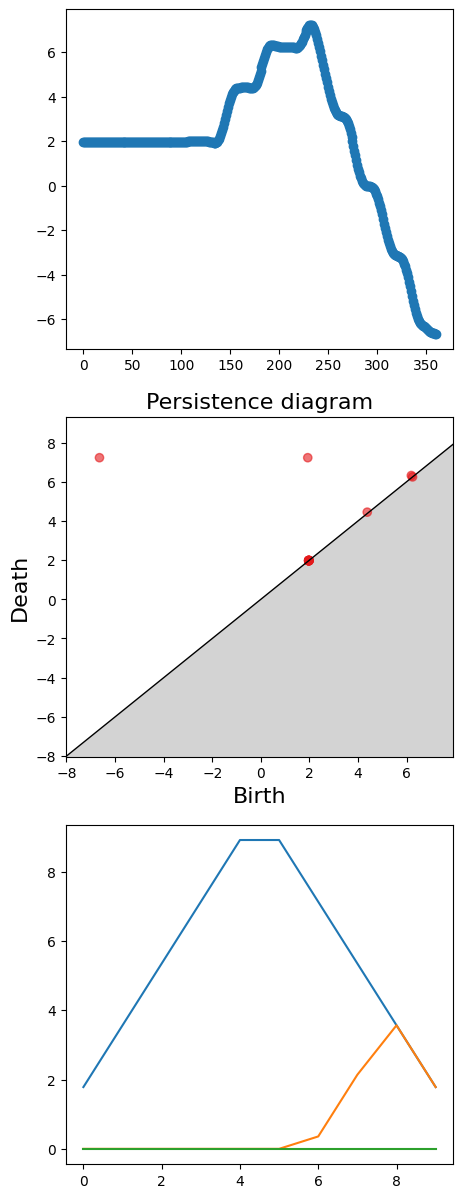

In [41]:
diagram = 3001
fig, axs = plt.subplots(3, 1, figsize=(5, 15))

diagrams = []
diagrams.append([
    paths[diagram],
    persistence[diagram],
    landscapes[diagram]
])
diagrams.append([
    sub_paths[diagram],
    sub_persistence[diagram],
    sub_landscapes[diagram]
])
diagrams.append([
    heading_sub_paths[diagram],
    heading_sub_persistence[diagram],
    heading_sub_landscapes[diagram]
])

i = 2

path = diagrams[i][0]
pers = diagrams[i][1]
landscape = diagrams[i][2]

axs[0].scatter(path[:, 0], path[:, 1])
gudhi.persistence_graphical_tools.plot_persistence_diagram(pers, axes=axs[1])

for i in range(n_landscapes):
    axs[2].plot(landscape[i*resolution:(i+1)*resolution])

In [42]:
 from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

from sklearn import svm

seed = 69

regressors = {
    "Support Vector Machines" : [svm.SVR(), {
        "C" : [0.5, 1, 2], 
        "degree": [2, 3, 4],
    }],
    "Base line" : [DummyRegressor(strategy = "mean"), {
        
    }],
    "Multi-layer Perception" : [MLPRegressor(random_state=seed, max_iter = 5000), {
        "hidden_layer_sizes" : [10, 20, 30], 
        
    }],
    "K Nearest Neighbors" : [KNeighborsRegressor(), {
        "n_neighbors" : [5, 10, 20, 40], 
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor" : [RandomForestRegressor(random_state=seed), {
        "max_depth": [3, 6], 
        "n_estimators" : [25, 50, 100]
    }],
    "Decision Tree Regressor" : [DecisionTreeRegressor(random_state=seed), {
        "min_samples_split" : [2, 3, 4],
        "min_samples_leaf" : [1, 2, 3]
    }],
}

classifiers = {
    "Support Vector Machines": [svm.SVC(random_state=seed), {
        "C": [1, 2, 3],
        "break_ties": [True, False],
        "probability": [True, False]
    }],
    "Base line": [DummyClassifier(strategy="most_frequent"), {

    }],
    "Multi-layer Perception": [MLPClassifier(random_state=seed, max_iter=5000), {
        "hidden_layer_sizes": [10, 20, 30],

    }],
    "K Nearest Neighbors": [KNeighborsClassifier(), {
        "n_neighbors": [5, 10, 20, 40],
        "p": [1, 2, 3]
    }],
    "Random Forrest Regressor": [RandomForestClassifier(random_state=seed), {
        "max_depth": [3, 6],
        "n_estimators": [50, 100, 300]
    }],
    "Decision Tree Regressor": [DecisionTreeClassifier(random_state=seed), {
        "min_samples_split": [2, 3, 4],
        "min_samples_leaf": [1, 2, 3]
    }],
}

In [58]:
B = [baseline, outside_data]
LL = [pers_stats]
A = [sub_pers_stats]
H = [heading_sub_pers_stats]
LL_A_H = LL + A + H
B_LL_A_H = B + LL_A_H

X = np.concatenate(H, axis= 1)

mask = ~np.any(np.isnan(X), axis=1)
X = X[mask]
Y = labels[mask]

indices = np.arange(len(X))

x_train, x_test_val, y_train, y_test_val, indices_train, indices_test_val = train_test_split(X, Y, indices, test_size=0.3, random_state=seed)

#normalizer = preprocessing.Normalizer()
#x_train = normalizer.fit_transform(x_train)
#x_test_val = normalizer.transform(x_test_val)

x_test, x_val, y_test, y_val, indices_test, indices_val = train_test_split(x_test_val, y_test_val, indices_test_val, test_size=0.5, random_state=seed)

In [59]:
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from sklearn.model_selection import GridSearchCV

datalist = []
models = classifiers if simple else regressors

for i in models.keys():
    #does the gridsearch on the models
    model = GridSearchCV(models[i][0], models[i][1])
    #makes a prediction
    prediction = np.floor(model.fit(x_train, y_train).predict(x_test))
    #finds out how good that prediction is
    
    balanced_accuracy = balanced_accuracy_score(y_test, prediction)
    datalist.append([model.best_estimator_, balanced_accuracy])

In [60]:
for i, j in datalist:
    print(f"{i.__repr__(): <70}: {j: .3}")

SVC(C=3, break_ties=True, probability=True, random_state=69)          :  0.967
DummyClassifier(strategy='most_frequent')                             :  0.5
MLPClassifier(hidden_layer_sizes=20, max_iter=5000, random_state=69)  :  0.978
KNeighborsClassifier(p=1)                                             :  0.981
RandomForestClassifier(max_depth=6, n_estimators=300, random_state=69):  0.981
DecisionTreeClassifier(min_samples_leaf=3, random_state=69)           :  0.972


In [61]:
new_x_train =  np.concatenate((x_train, x_test), axis=0)
new_y_train = np.concatenate((y_train, y_test), axis=0)
best_model = sorted(datalist, key=lambda x: x[1], reverse=True)[0][0]

prediction = np.floor(best_model.fit(new_x_train, new_y_train).predict(x_val))
balanced_accuracy = balanced_accuracy_score(y_val, prediction)
balanced_accuracy

0.9814916275725096

In [62]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, prediction)

array([[624,  12],
       [ 10, 541]], dtype=int64)

Where the columns is prediction and the rows are the true value.
i will note that the dataset is not 100% accurate. there are false positives:



The GA detection algorithm sometimes fails to detect GAs either:
* if GAs are initialized early on the approach and have no or only a short climb phase, 
* if GAs have a very tight turn radius and only a short leg on the final approach (as usually performed by small general aviation aircraft), or 
* if GAs directly divert to other airports.

### adding sublevel set height:
this doesnt seem to improve the results, and mostly just confuses the models :/


In [18]:
false_negatives = np.where(np.logical_and(y_val == 1, prediction == 0))[0]
false_positives = np.where(np.logical_and(y_val == 0, prediction == 1))[0]
positives = np.where(y_val == 1)[0]


index = 0
index = indices_val[false_positives[index]]
#index = indices_val[false_negatives[index]]

fig, axs = plt.subplots(2, 2, figsize=(10, 10))
path = paths[index]
axs[0, 0].scatter(path[:, 0], path[:, 1])

path = sub_paths[index]
axs[0, 1].scatter(path[:, 0], path[:, 1])

gudhi.persistence_graphical_tools.plot_persistence_diagram(sub_persistence[index], axes=axs[1, 1])
gudhi.persistence_graphical_tools.plot_persistence_diagram(persistence[index], axes=axs[1, 0])

IndexError: index 0 is out of bounds for axis 0 with size 0

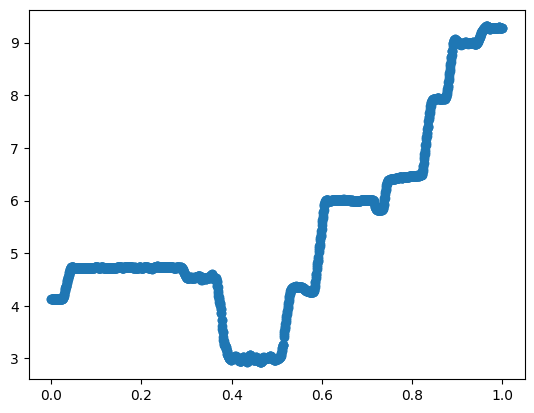

In [145]:
index = 30
data = flights[index].data
path = np.unwrap(np.deg2rad(data["track"]), period=2 * np.pi, discont=np.pi)

x_values = [x / len(path) for x in range(len(path))]
plt.scatter(x_values, path)